Energy forecast with ML

In [25]:
import kaggle
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

kaggle.api.authenticate()

In [26]:
# see the available datasets in kaggle related to energy
!kaggle datasets list -s 'energy'

ref                                                             title                                                   size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
robikscube/hourly-energy-consumption                            Hourly Energy Consumption                           11979477  2018-08-30 14:17:03.317000          92152       1058  1.0              
pralabhpoudel/world-energy-consumption                          World Energy Consumption                             2363711  2023-11-26 00:57:10.697000          22397        202  1.0              
unitednations/international-energy-statistics                   International Energy Statistics                      7709566  2017-11-16 00:06:06.683000          13233        289  0.7058824        
loveall/ap

In [27]:
#Download the dataset and store it in the data folder 
#kaggle.api.dataset_download_files('robikscube/hourly-energy-consumption', path='./data', unzip=True) 

In [28]:
henergy_df = pd.read_csv("..\data\AEP_hourly.csv")
henergy_df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


EDA

In [29]:
# check if the data has missing values
henergy_df.notna().value_counts()

Datetime  AEP_MW
True      True      121273
dtype: int64

In [30]:
henergy_df.Datetime = pd.to_datetime(henergy_df.Datetime)
henergy_df.info

<bound method DataFrame.info of                   Datetime   AEP_MW
0      2004-12-31 01:00:00  13478.0
1      2004-12-31 02:00:00  12865.0
2      2004-12-31 03:00:00  12577.0
3      2004-12-31 04:00:00  12517.0
4      2004-12-31 05:00:00  12670.0
...                    ...      ...
121268 2018-01-01 20:00:00  21089.0
121269 2018-01-01 21:00:00  20999.0
121270 2018-01-01 22:00:00  20820.0
121271 2018-01-01 23:00:00  20415.0
121272 2018-01-02 00:00:00  19993.0

[121273 rows x 2 columns]>

In [31]:
henergy_df = henergy_df.set_index(henergy_df['Datetime'])
henergy_df= henergy_df.drop(['Datetime'], axis=1)
henergy_df.index.min

<bound method Index.min of DatetimeIndex(['2004-12-31 01:00:00', '2004-12-31 02:00:00',
               '2004-12-31 03:00:00', '2004-12-31 04:00:00',
               '2004-12-31 05:00:00', '2004-12-31 06:00:00',
               '2004-12-31 07:00:00', '2004-12-31 08:00:00',
               '2004-12-31 09:00:00', '2004-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=121273, freq=None)>

In [32]:
# Plot each year's time series in its own facet
def extract_time_data(df_o):
    df= df_o.copy()
    df['Year'] =  df.index.year
    df['Month'] = df.index.month
    df['Day'] = df.index.day
    df['Hour'] = df.index.hour
    return df

henergy_df = extract_time_data(henergy_df)
henergy_df.head()

,AEP_MW,Year,Month,Day,Hour
Datetime,,,,,
2004-12-31 01:00:00,13478.0,2004,12,31,1
2004-12-31 02:00:00,12865.0,2004,12,31,2
2004-12-31 03:00:00,12577.0,2004,12,31,3
2004-12-31 04:00:00,12517.0,2004,12,31,4
2004-12-31 05:00:00,12670.0,2004,12,31,5


<AxesSubplot:ylabel='AEP_MW'>

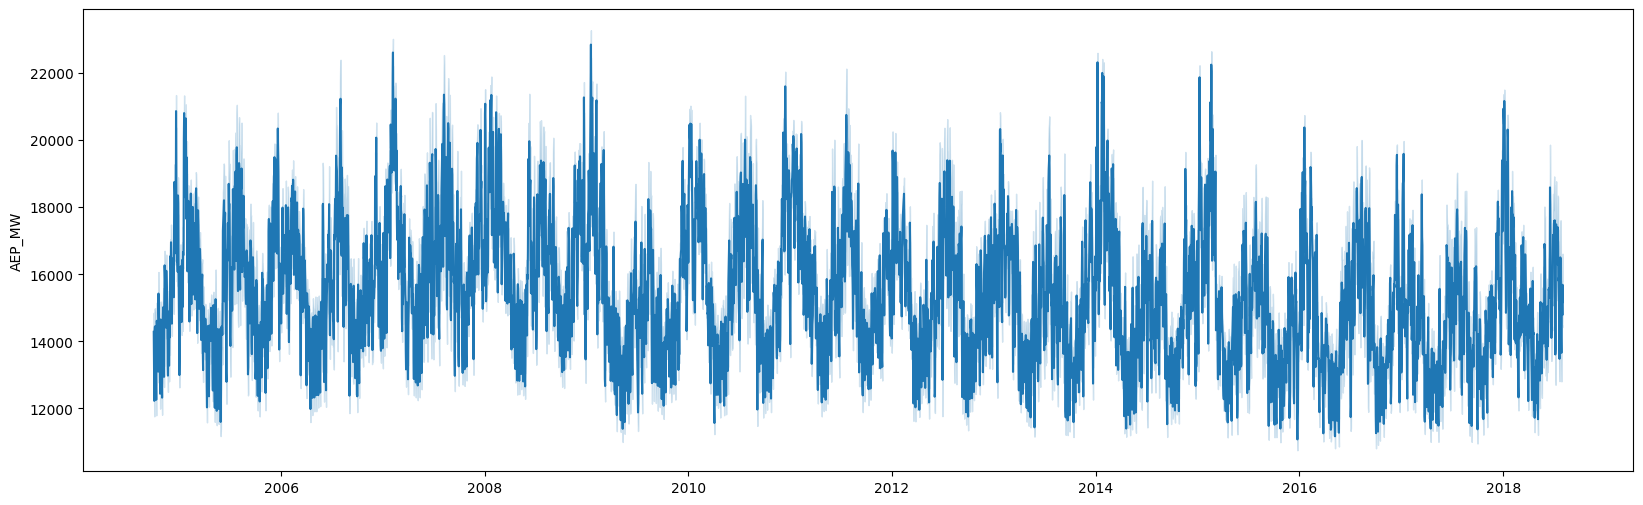

In [39]:
fig = plt.figure(figsize=(20, 6))
sns.lineplot(data=henergy_df, x=henergy_df.index.date, y='AEP_MW')

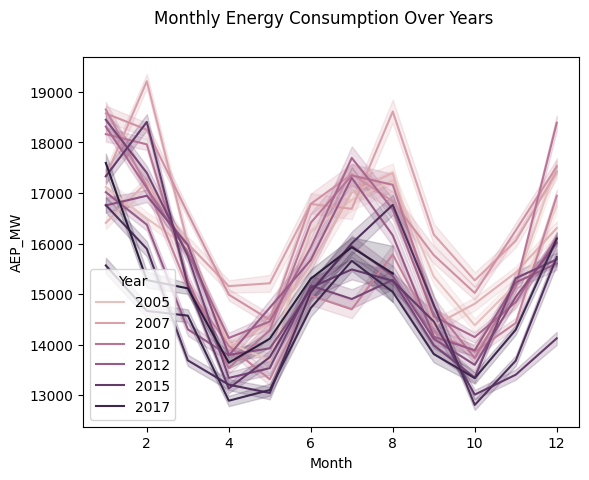

In [34]:
sns.lineplot(henergy_df, y='AEP_MW', x = 'Month', hue='Year')
plt.suptitle('Monthly Energy Consumption Over Years')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


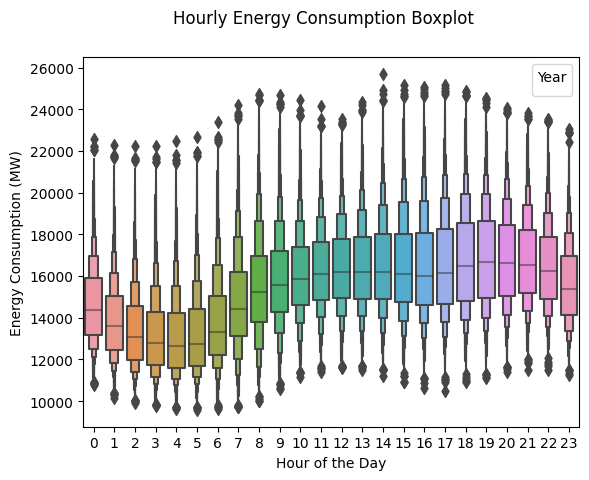

In [35]:
sns.boxenplot(henergy_df, y='AEP_MW', x = 'Hour')
plt.suptitle('Hourly Energy Consumption Boxplot')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Consumption (MW)')
plt.legend(title='Year')
plt.show()

<AxesSubplot:xlabel='Day', ylabel='AEP_MW'>

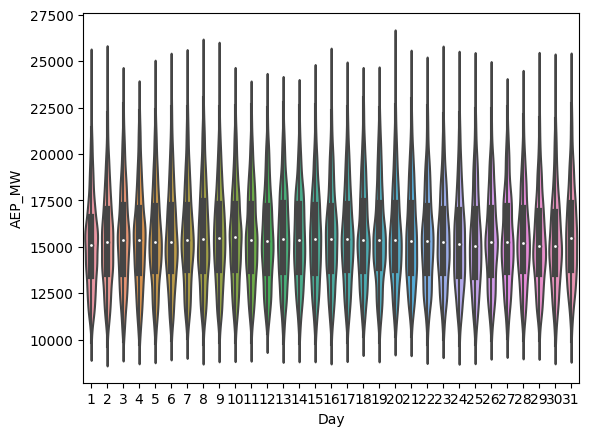

In [36]:
sns.violinplot(henergy_df, y='AEP_MW', x = 'Day')